# Post-analysis of Spindles, SWR and Down-states.

Restart from SWR and spindles verified files. They are most likely the .csv files.

## Load events files and packages

In [41]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
import seaborn as sns
from pathlib import Path


sns.set(style="whitegrid", palette="muted")
%matplotlib widget

folder_base = Path('/Users/ahay/Documents/DATA/OPNE/ArchTshort/OD1/')
filenameSp = folder_base / f'TTLproperties.csv'
filenameSwr = folder_base / f'SWRproperties.csv'
filenameNW = folder_base / f'LFPwakeremoved.npy'
filenameAll = folder_base / f'RawDataChannelExtractedDS.npy'

#SpindlesS1 = pd.read_csv(filenameSp)
PFCspiprop = pd.read_csv(filenameSp)
SWRprop = pd.read_csv(filenameSwr)
LFPwakeremoved = np.load(filenameNW, mmap_mode= 'r')
All = np.load(filenameAll, mmap_mode= 'r')
All = All.T
PFC = All[:, 10]
PFCwakeremoved = LFPwakeremoved[:, 10]


In [2]:
len(PFCspiprop)

89

In [42]:
SWRprop
SWRprop.describe()
r = np.corrcoef(SWRprop['Duration'], SWRprop['Avg int'])
r[0, 1] # -0.1757 No correlation!
r = np.corrcoef(SWRprop['Avg freq'], SWRprop['Avg int'])
r[0, 1] # 0.2528 No correlation!
r = np.corrcoef(SWRprop['Avg freq'], SWRprop['Duration'])
r[0, 1] # -0.2478 No correlation!

-0.11693962299782604

Text(0, 0.5, 'Intensity (AU)')

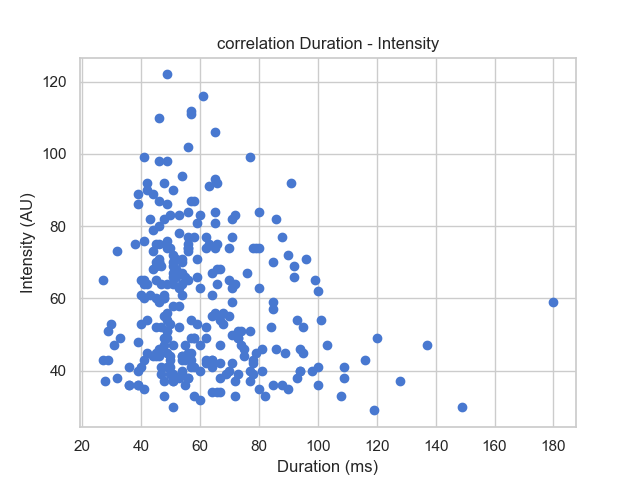

In [3]:
fig, ax = plt.subplots()
ax.plot(SWRprop['Duration'], SWRprop['Avg int'], marker='o', linewidth=0)
ax.set_title('correlation Duration - Intensity')
ax.set_xlabel('Duration (ms)')
ax.set_ylabel('Intensity (AU)')

In [4]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

determine the coupling of spindles and swrs

In [5]:
before = 100 # ms
after = 00 # ms
counterPFC = 0
Coupled_spindlesPFC = list()
unCoupled_spindlesPFC = list()

nb_spindle = PFCspiprop.shape[0]
print(nb_spindle)
for Pspin in range(nb_spindle-2):
    ser = pd.Series(PFCspiprop["peak time"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterPFC = counterPFC + 1
        Coupled_spindlesPFC.append(Pspin)
    else:
        unCoupled_spindlesPFC.append(Pspin)

print(len(Coupled_spindlesPFC))
print(len(unCoupled_spindlesPFC))
print(len(Coupled_spindlesPFC)/(len(Coupled_spindlesPFC)+len(unCoupled_spindlesPFC)))

100


KeyError: 'peak time'

number of events 

In [7]:
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]

timesleeping = len(PFCwakeremoved)/1000
IncSpin =  nb_spindle/timesleeping
IncSWR =  nb_swr/timesleeping

print(IncSpin)
print(IncSWR)

0.09532745516396322
0.7765438763356555


event properties

In [8]:
print("SWR")
print(np.mean(SWRprop['Avg int']))
print(np.mean(SWRprop['Max int']))
print("Spindle")
print(np.mean(PFCspiprop['Avg int']))
print(np.mean(PFCspiprop['Max int']))


SWR
97.26344827586207
247.03172413793104
Spindle
1757.4719101123596
3460.955056179775


2205
Baseline: neg coupling 0.11; pos coupling 0.1; all coupling 0.22; inc spi 0.05 ev/sec; inc swr 0.19 ev/sec
            avg/max int swr 236/610; avg/max int spi 257/781
DCZ: neg coupling 0.12; pos coupling 0.09; all coupling: 0.21; inc spi 0.05 ev/sec; inc swr 0.21 ev/sec
            avg/max int swr 219/569; avg/max int spi 240/747

2206
Baseline: neg coupling 0.31; pos coupling 0.28; all coupling 0.59; inc spi 0.06 ev/sec; inc swr 0.56 ev/sec
            avg/max int swr 445/1142; avg/max int spi 2394/7232
DCZ: neg coupling 0.23; pos coupling 0.23; all coupling: 0.47; inc spi 0.04 ev/sec; inc swr 0.32 ev/sec
            avg/max int swr 413/1068; avg/max int spi 2221/6773

2207
Baseline: inc spi 0.043 ev/sec; 
            avg/max int spi 257/781
DCZ: inc spi 0.063 ev/sec;
            avg/max int spi 2119/6370

Histogramme de répartition des SWR around light stim

In [33]:
folder_base = Path('/Users/ahay/Documents/DATA/OPNE/ArchTshort/OD2/')
filenameSp = folder_base / f'TTLproperties.csv'
filenameSwr = folder_base / f'SWRproperties.csv'
SpindlesS1 = pd.read_csv(filenameSp)
PFCspiprop = pd.read_csv(filenameSp)
SWRprop = pd.read_csv(filenameSwr)


counterPFC = 0
#Distance_SWRstim = list()
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]
#whatareyou = list()

print(nb_spindle)
for Pspin in range(nb_spindle-2):
    ser = pd.Series(PFCspiprop["Start"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if distance < 2100 and distance > -2100:
        Distance_SWRstim.append(distance)
    if distance < 200 and distance > 0:
        whatareyou.append(Pspin)
print(whatareyou)

plt.close() 
plt.hist(Distance_SWRstim, bins=[-2100, -1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100])
plt.show() 

100


KeyError: -1

In [34]:
len(Distance_SWRstim)
#Distance_SWRstim

98

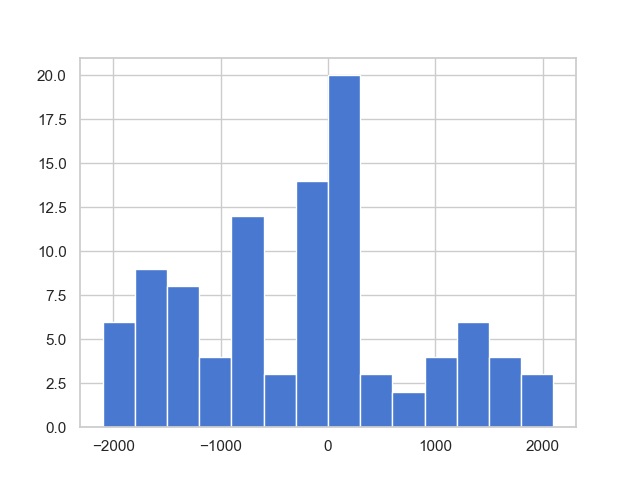

In [40]:

plt.close() 
plt.hist(Distance_SWRstim, bins=[-2100, -1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100])
#plt.hist(Distance_SWRstim, bins=[-2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000])
#plt.hist(Distance_SWRstim, bins=[-2100, -1400, -700, 0, 700, 1400, 2100])
plt.show() 

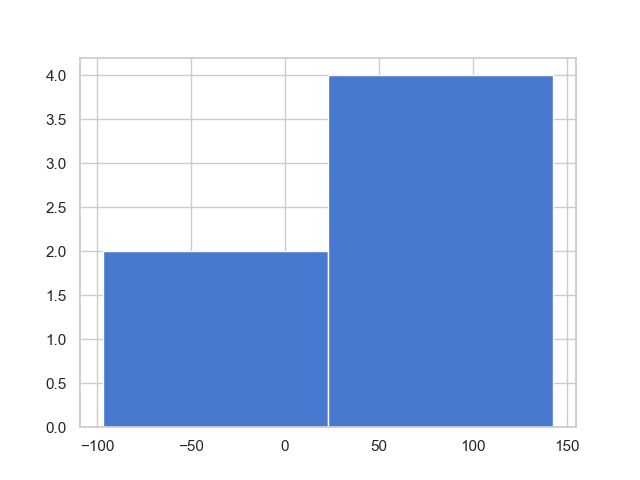

In [9]:
Distance_SWRstim2 = np.array(Distance_SWRstim)
Distance_SWRstim3 = Distance_SWRstim2[Distance_SWRstim2<150]
Distance_SWRstim4 = Distance_SWRstim3[Distance_SWRstim3>-150]

plt.close() 
plt.hist(Distance_SWRstim4, bins=2)
plt.show() 

In [136]:
counterPFC = 0
Distance_stimSWR = list()
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]

print(nb_swr)
for Pspin in range(nb_swr-20):
    ser = pd.Series(PFCspiprop["end time"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest(ser, serSWR[Pspin])
    distance = Combined_Spindle_SWR - serSWR[Pspin]
    Distance_stimSWR.append(distance)

print(len(Distance_stimSWR))

725
705


In [10]:
Distance_stimSWR2 = np.array(Distance_stimSWR)
Distance_stimSWR3 = Distance_stimSWR2[Distance_stimSWR2<500]
Distance_stimSWR4 = Distance_stimSWR3[Distance_stimSWR3>-500]

plt.close() 
plt.hist(Distance_stimSWR4, bins=21)
plt.show() 

NameError: name 'Distance_stimSWR' is not defined